# Forêts aléatoires

## Principe
Le bagging semble performant quand il est appliqué à des fonctions d'estimation de faible biais mais de forte variance. C'est le cas en particulier des arbres de décision ou de régression.

 La méthode des forêts aléatoires modifie l'algorithme du bagging en ajoutant un critère de décorrélation entre les arbres.  Elle utilise des arbres de décision comme classifieurs partiellement indépendants. L'algorithme entraîne chaque arbre de décision sur un échantillonnage de $Z$ obtenu par bootstrapping  selon un algorithme d'apprentissage sur les arbres (CART sans élagage par exemple),  en limitant sa croissance par validation croisée.  

La justification de cette approche est la suivante. Lorsque que l'on calcule la moyenne de $n$ variables aléatoires, chacune de variance $\sigma^2$, la variance globale est de : $\frac{1}{n}\sigma^2$. Si les variables sont seulement identiquement distribuées mais non nécessairement indépendantes, et de corrélation par paires $\rho$, alors la variance globale est : $\rho\, \sigma^2 + \frac{1 - \rho}{n} \sigma^2$, dans laquelle le second terme tend vers 0 quand $n$ augmente. 

L'idée de la méthode des forêts aléatoires est ainsi de réduire la corrélation $\rho$ sans augmenter trop la variance. La technique utilisée consiste à sélectionner aléatoirement un sous-ensemble de $k$ variables à considérer à chaque étape de choix du meilleur noeud de l'arbre. 

## Algorithme

### Algorithme des forêts aléatoires

L'{prf:ref}`rf-algorithm` décrit la procédure générale de construction d'une forêt aléatoire.



```{prf:algorithm} 
:label: rf-algorithm
**Entrée** : l'ensemble d'apprentissage $Z$, $\mathbf x\in X$, $M$ le nombre d'arbres, $k$

**Sortie** : Un classifieur $h$


Pour $i= 1$ à $M$
  1. Tirer avec remise dans $Z$ un sous-échantillon $Z_i$ (bootstrap)
  2. Construire un arbre CART $h_i(.)$ sur $Z_i$, chaque coupure est sélectionnée en minimisant la fonction de coût de CART sur un ensemble de $k$ variables choisies au hasard

$h(\mathbf x)=\frac{1}{M}\displaystyle\sum_{i=1}^M h_i(\mathbf x)$ 
```


### Choix de $k$
On retrouve dans le choix de $k$ un compromis biais-variance :


-  lorsque $k$ diminue, la tendance est à se rapprocher d'un choix aléatoire des variables
de découpe des arbres. Dans le cas où $k = 1$, les axes de la partition des arbres
sont choisis au hasard, et seuls les points de coupure utiliseront l'échantillon. Ainsi, la corrélation entre les arbres a  tendance à diminuer également, ce qui entraîne une baisse de la variance de l'estimateur agrégé. En revanche, choisir les axes de découpe des arbres de manière (presque) aléatoire  se traduit par une moins bonne qualité d'ajustement des arbres sur l'échantillon d'apprentissage, d'où une augmentation du biais pour chaque arbre $h_i$ ainsi que pour $h$.
-  lorsque $k$ augmente, les phénomènes inverses se produisent.



Le choix de $k$ est donc lié aux choix des paramètres de l'arbre, notamment au choix du nombre d'observations dans ses noeuds terminaux. En pratique, le nombre maximum d'observations dans les noeuds est par défaut pris relativement petit (de l'ordre de 5 en régression, 1 en classification), ou alors optimisé par validation croisée.

## Exemples
### Illustration en classification
Le code suivant présente la classification du jeu de données Moons par une forêt aléatoire à 500 arbres de décision

Précision sur l'ensemble de test 0.8857142857142857


Text(0.5, 1.0, 'Forêt aléatoire')

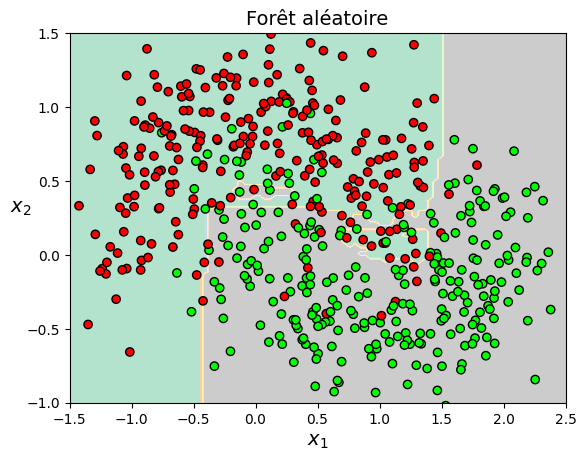

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier

X, y = make_moons(n_samples=700, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    mapp = ListedColormap(['#FF0000', '#00FF00'])
    map = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=1, cmap='Pastel2')
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=mapp,edgecolors='k')
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)



rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

print("Précision sur l'ensemble de test", np.sum(rnd_clf.predict(X_test) == y_test) / len(y_test))
plot_decision_boundary(rnd_clf, X_train, y_train,contour=False)
plt.title("Forêt aléatoire", fontsize=14)


In [2]:
from IPython.display import Video
Video("videos/randomForestClassification.mp4",embed =True,width=500)

### Illustration en régression
On construit une fonction périodique bruitée $f(x) = \sin(5x)+sin(\frac{x}{2}) + \sigma$, $\sigma$ suivant une loi normale $\mathcal{N}(0,1)$. Le code suivant présente la régression obtenue par forêt aléatoire de 300 arbres.

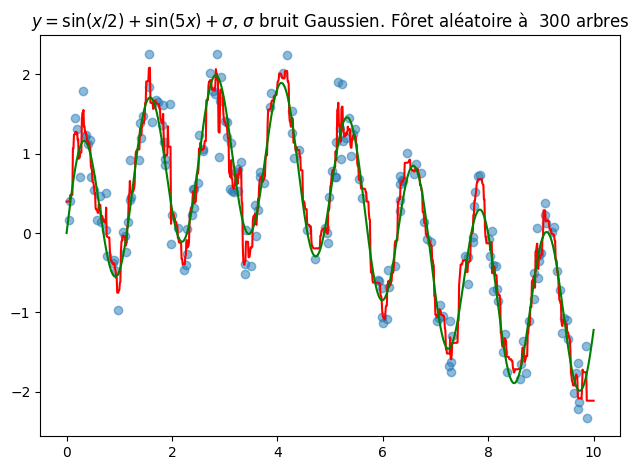

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

rng = np.random.RandomState(42)

def f(x, sigma=0.3):
    return  np.sin(0.5 * x) + np.sin(5 * x) + sigma * rng.randn(len(x))

num = 300
x = 10 * rng.rand(200)
y = f(x)

forest = RandomForestRegressor(num)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = f(xfit, sigma=0)

fig = plt.figure()
plt.scatter(x, y, alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-g');
plt.title('$y=\sin(x/2) +\sin(5x) +  \sigma$, $\sigma$ bruit Gaussien. Fôret aléatoire à  {0:d} arbres'.format(num));
plt.tight_layout()

In [4]:
from IPython.display import Video
Video("videos/randomForestRegression.mp4",embed =True,width=500)